# On Analyzing Real World Time Series for Forecasting Stock Data - Apple Returns Data
- TUTORIAL: [simplestockpredictionautoregression.ipynb](https://gist.github.com/DanielWicz/e2f90648e46da599080fed70d11cc09c)
- I also have the code in the play folder. Have my code resemble his.
- With splitting data


## TODOs
- [x] Autoget list of lags
- [x] Reconfigure AR model to train same model every lag (and NOT a new model per lag)
- [x] Reconstruct my plots to be like his
- [ ] Fix Table of Contents/Steps

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

from collections import namedtuple
from data_loader import build_stock_uts
from ts_models import Model, PersistenceWalkForward, AR, MA, ARMA, EvaluationMetric
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Stock Data Analysis with Forecasts

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data
11. Split Returns Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
24. Follow-up

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2011-01-01", "2021-01-01"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("AAPL", "Apple"),
    ("INTC", "Intel")
]
independent_variable = "Close"
# frequency = 
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date, frequency='1d') for s in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

In [4]:
stock_symbol = 'AAPL'
type(stocks[stock_symbol]), stocks[stock_symbol]

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [5]:
stock_series = stocks[stock_symbol].get_series()
stock_series

array([ 11.77035713,  11.83178616,  11.92857075, ..., 134.86999512,
       133.72000122, 132.69000244])

In [6]:
stock_df = stocks[stock_symbol].get_as_df()
stock_df

Close
Date                  
2011-01-03   11.770357
2011-01-04   11.831786
2011-01-05   11.928571
2011-01-06   11.918929
2011-01-07   12.004286
...                ...
2020-12-24  131.970001
2020-12-28  136.690002
2020-12-29  134.869995
2020-12-30  133.720001
2020-12-31  132.690002

[2517 rows x 1 columns]

### Plot Raw Data

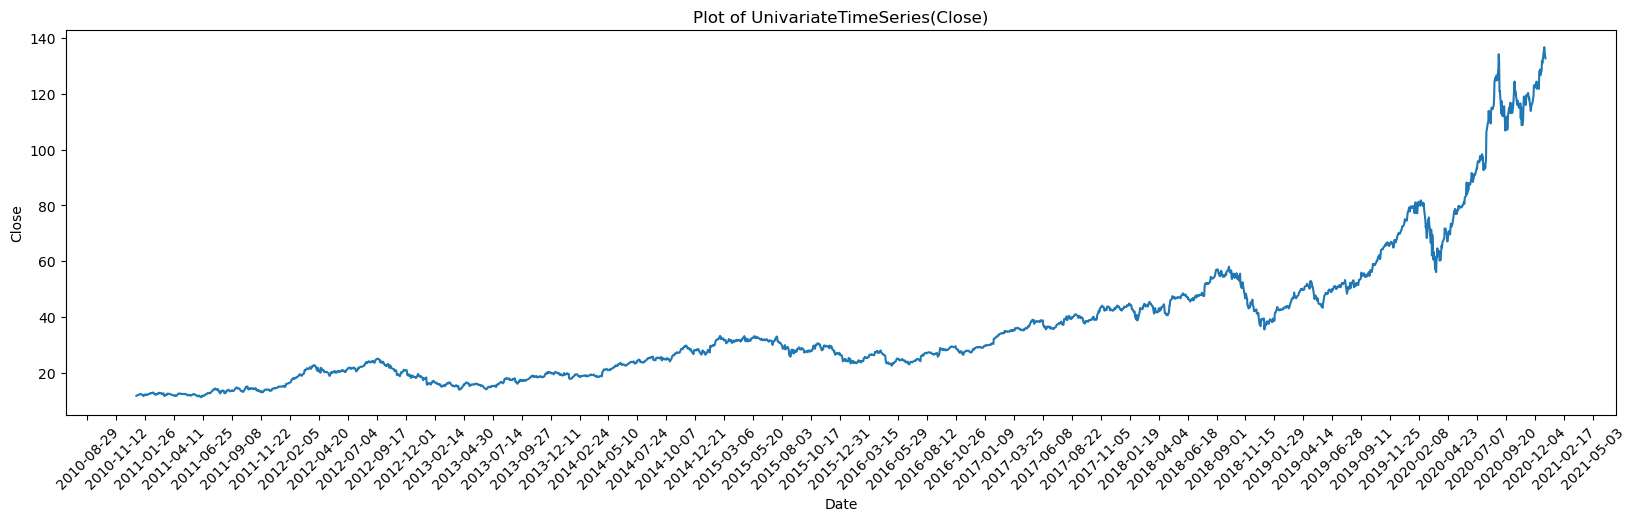

In [7]:
stocks[stock_symbol].plot(tick_skip=75)

### Get Descriptive Statistics of Raw Data

In [8]:
stocks[stock_symbol].get_statistics()

Close
count  2517.000000
mean     36.230201
std      24.453886
min      11.261429
25%      19.609644
50%      28.262501
75%      43.970001
max     136.690002

In [9]:
stocks[stock_symbol].max_min_range()

{'Max': Close    136.690002
 dtype: float64,
 'Min': Close    11.261429
 dtype: float64,
 'Range': Close    125.428574
 dtype: float64}

In [10]:
stocks[stock_symbol].autocorrelation(3)

0.9875450100646932

- How come we don't use the partial ACorr values?

In [24]:
threshold_acorrs = stocks[stock_symbol].autocorrelation_with_threshold()
len(threshold_acorrs)

738

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary.
    - Can we verify this non-stationary with plotting the Autocorrelation?

In [12]:
stocks[stock_symbol].stationarity_test(stock_df)

ADF Statistic: 3.302925
p-value: 1.000000 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

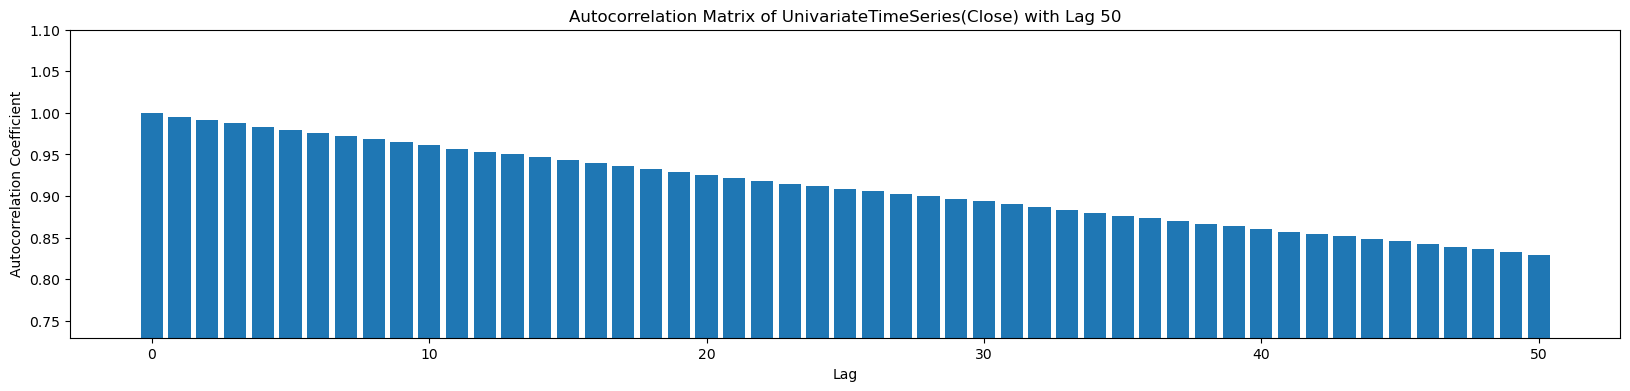

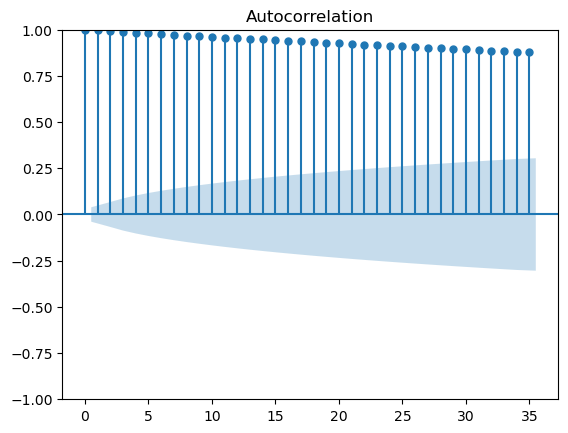

In [13]:
stocks[stock_symbol].plot_autocorrelation(50)

- Above, the data is highly correlated which means that the k-th lag observation has some impact on the most recent observation.

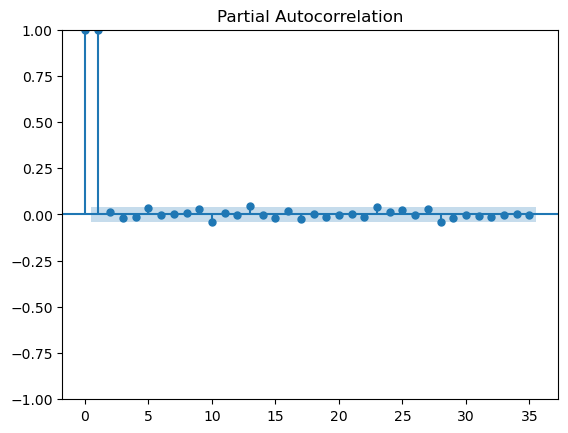

In [14]:
stocks[stock_symbol].plot_partial_autocorrelation(35)

- Above, the data shows a rapid decay at lag 2. 

- The Partial ACorr rapidly decays as lag observation 1, so if we use an MA, we'd go with AR(1).

In [15]:
len(stocks[stock_symbol].get_series()), stocks[stock_symbol].get_series()

(2517,
 array([ 11.77035713,  11.83178616,  11.92857075, ..., 134.86999512,
        133.72000122, 132.69000244]))

### Initialize Autoregressive AR(p) Model

- How to determine the proper lag value? Look at the Partial ACor plot.

#### 10 Day Forecast

In [22]:
days_to_forecast = [10, 366]

for i in range(len(days_to_forecast)):
    total_days = len(stocks[stock_symbol].get_series())
    print(f'Total days {total_days}\n')
    test_days = days_to_forecast[i]
    print(f'Test days considered {test_days}\n')
    training_days = total_days - test_days
    print(f'Training days considered {training_days}\n')

Total days 2517

Test days considered 10

Training days considered 2507

Total days 2517

Test days considered 366

Training days considered 2151



In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
# New model for each new X day forecast
trained_ar_models = []
train_labels = []
true_labels = []

for i in range(len(days_to_forecast)):
    print(f'{days_to_forecast[i]} Day Forecast')
    
    train_data = stocks[stock_symbol].get_as_df()[:-days_to_forecast[i]]
    print(f'Length of training days {len(train_data)}')
    # print(train_data)
    train_labels.append(train_data)
    
    true_data = stocks[stock_symbol].get_as_df()[-days_to_forecast[i]:]
    print(f'Length of testing days {len(true_data)}')
    # print(true_labels) 
    true_labels.append(true_data)
    
    # create an object from the AR() class
    ar_model_class = AR()

    # call the function to train our AR model
    trained_ar_model = ar_model_class.train_ar_model(train_data, threshold_acorrs)
    print(f'{days_to_forecast[i]} Day Forecast Model: {trained_ar_model}\n')
    trained_ar_models.append(trained_ar_model)

10 Day Forecast
Length of training days 2507
Length of testing days 10
10 Day Forecast Model: <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a4aa8df0>

366 Day Forecast
Length of training days 2151
Length of testing days 366
366 Day Forecast Model: <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a4aa4f10>



### Predict + Plot Actual Forecasts vs Predicted Forecasts for Raw Data

10 Day Forecasts: 
[2507    128.353352
2508    123.568139
2509    126.999304
2510    123.848398
2511    123.988623
2512    121.638302
2513    122.709953
2514    123.174798
2515    123.884669
2516    124.614827
dtype: float64]


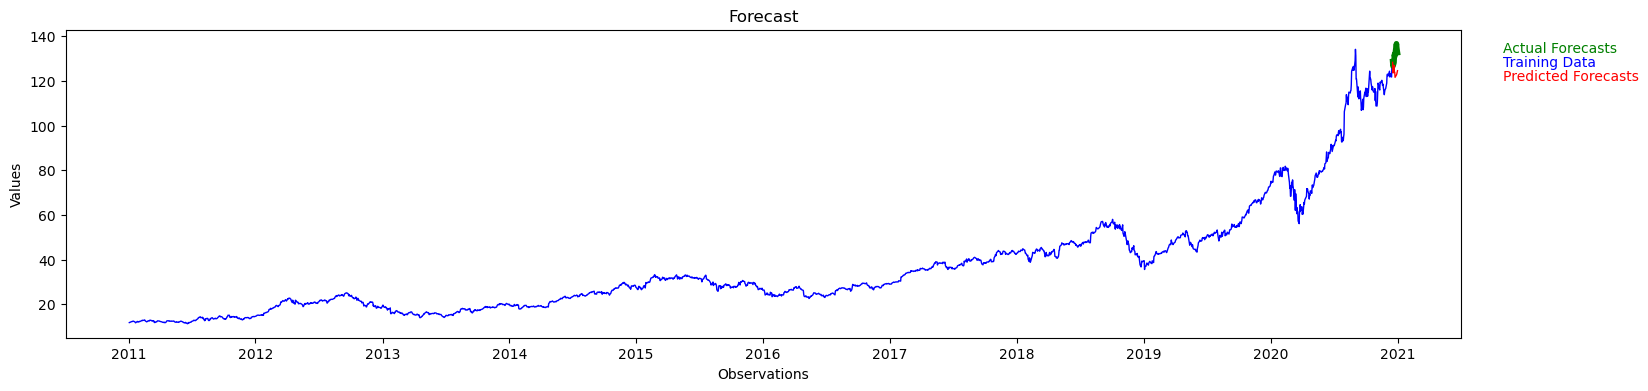

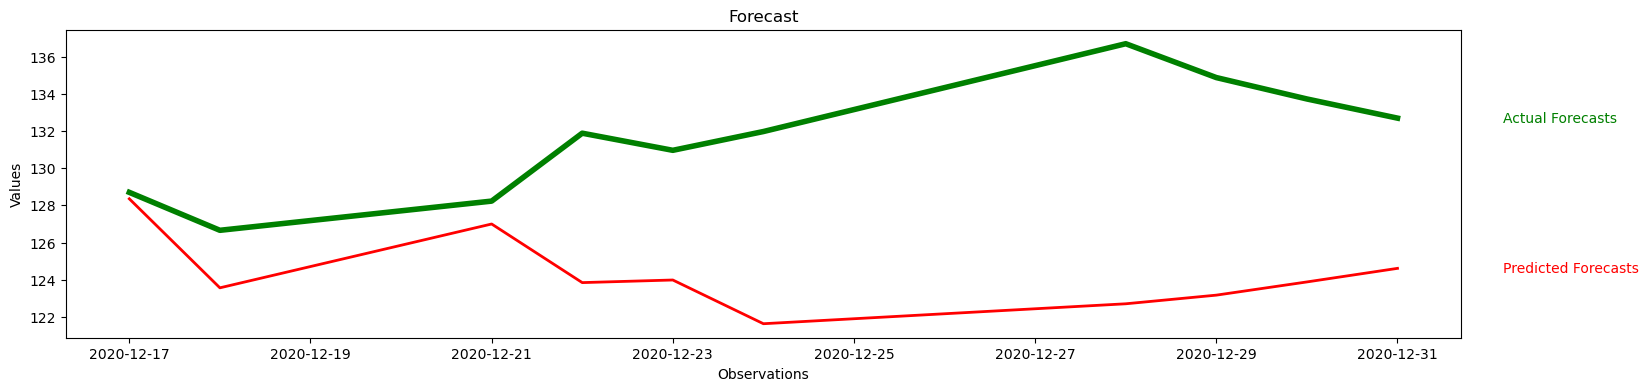



366 Day Forecasts: 
[2151    51.859933
2152    51.134706
2153    50.847457
2154    51.293904
2155    50.792728
          ...    
2512    74.238620
2513    76.514886
2514    73.892421
2515    75.549820
2516    77.093032
Length: 366, dtype: float64]


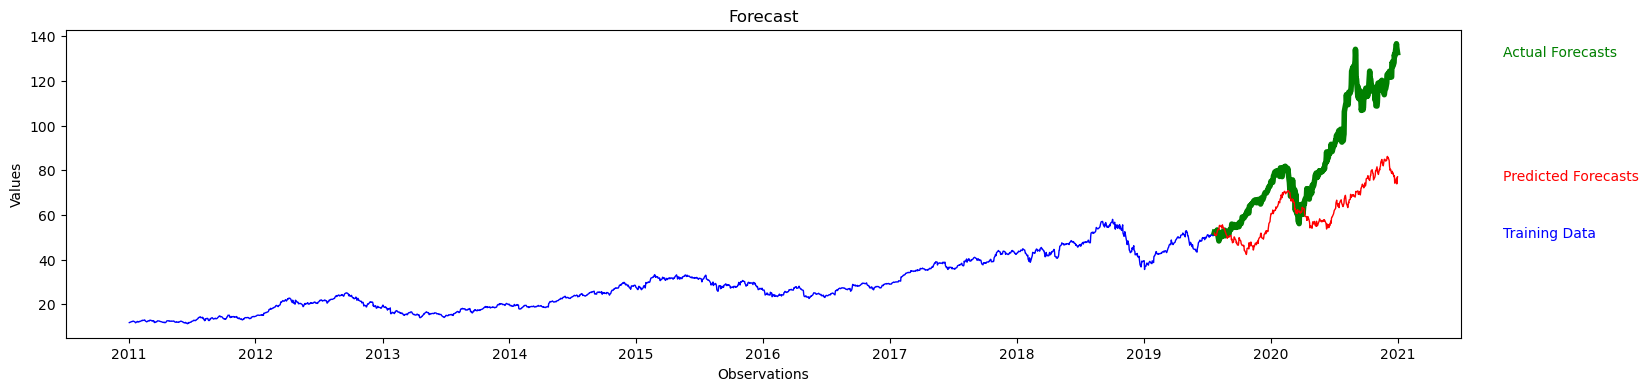

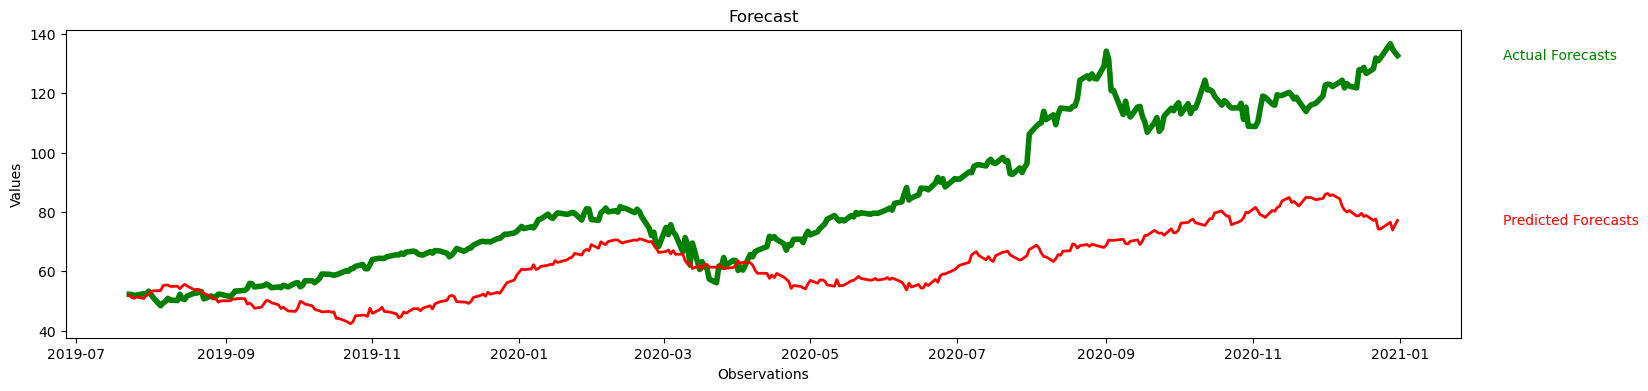

In [19]:
# New forecasting model for each new X day forecast
ar_forecasts = []

for i in range(len(trained_ar_models)):
    ar_forecast = ar_model_class.predict(trained_ar_models[i], train_labels[i], true_labels[i])
    print(f'{days_to_forecast[i]} Day Forecasts: \n{ar_forecast}')
    
    EvaluationMetric.plot_forecast(train_labels[i], true_labels[i], ar_forecast)
    EvaluationMetric.plot_forecast_only(true_labels[i], ar_forecast)
    
    print("\n")

### Follow-up
- What can we determine from this?
    - 10 Day Forecast:
        - Actual Forecast (with the real prices): We'd want to buy on 2020-12-18 and sell on 2020-12-28.
        - Predicted Forecast (`AR` model): We'd want to by on 2020-12-18 and sell on 2020-12-21.
        - Predicted Forecast (`AR` model): We'd want to by on 2020-12-24 and sell on 2020-12-31.
- Can we do better?
    - We only consider AR. The data could have multicollinearity [some of the lagged variables provide redundant information], thus we can remove this with differencing. 
- What to consider?
    - [ ] Log Likelihood
    - [ ] AIC
    - [ ] BIC
    - [ ] HQIC
    - [ ] Ljung-Box (L1) (Q)
    - [ ] Jarque-Bera (JB)
    - [ ] Prob(Q):
    - [ ] Prob(JB):
    - [ ] Heteroskedasticity (H):
    - [ ] Skew
    - [ ] Prob(H) (two-sided)
    - [ ] Kurtosis